In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v1", render_mode="human")


In [3]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

policy_net = QNetwork(env.observation_space.shape[0], env.action_space.n)
target_net = QNetwork(env.observation_space.shape[0], env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [4]:
num_episodes = 500
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
target_update_interval = 10

In [5]:
def select_action(state, policy_net, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            return torch.argmax(policy_net(torch.FloatTensor(state))).item()

In [6]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(max_size=10000)

In [7]:
optimizer = optim.Adam(policy_net.parameters())
rewards = []

# Ciclo de entrenamiento
for episode in range(num_episodes):
    state, info = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, policy_net, epsilon)
        next_state, reward, done, truncated, info = env.step(action)

        # Almacenar la experiencia
        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Renderizar el entorno
        env.render()  # Esto mostrará el entorno en una ventana

        # Actualizar la red
        if len(replay_buffer) > batch_size:
            experiences = replay_buffer.sample(batch_size)
            batch = list(zip(*experiences))
            states, actions, rewards_batch, next_states, dones = [torch.FloatTensor(x) for x in batch]
            actions = actions.long()

            q_values = policy_net(states)
            next_q_values = target_net(next_states)
            targets = rewards_batch + (1 - dones) * gamma * next_q_values.max(1)[0]

            # Actualizar la red
            optimizer.zero_grad()
            loss = nn.MSELoss()(q_values.gather(1, actions.unsqueeze(1)).squeeze(), targets.detach())
            loss.backward()
            optimizer.step()

    rewards.append(total_reward)

    # Actualizar epsilon
    if episode < 100:
        epsilon = 1.0 - (episode / 100)
    else:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Actualizar red de destino
    if episode % target_update_interval == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# Cerrar el entorno al final
env.close()

Episode 1, Total Reward: 26.0
Episode 2, Total Reward: 18.0


C:\Users\erick\AppData\Local\Temp\ipykernel_18700\1687332840.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  states, actions, rewards_batch, next_states, dones = [torch.FloatTensor(x) for x in batch]


Episode 3, Total Reward: 33.0
Episode 4, Total Reward: 15.0
Episode 5, Total Reward: 27.0
Episode 6, Total Reward: 27.0
Episode 7, Total Reward: 15.0
Episode 8, Total Reward: 12.0
Episode 9, Total Reward: 13.0
Episode 10, Total Reward: 20.0
Episode 11, Total Reward: 10.0
Episode 12, Total Reward: 18.0
Episode 13, Total Reward: 20.0
Episode 14, Total Reward: 16.0
Episode 15, Total Reward: 22.0
Episode 16, Total Reward: 44.0
Episode 17, Total Reward: 20.0
Episode 18, Total Reward: 44.0
Episode 19, Total Reward: 22.0
Episode 20, Total Reward: 15.0
Episode 21, Total Reward: 15.0
Episode 22, Total Reward: 25.0
Episode 23, Total Reward: 18.0
Episode 24, Total Reward: 9.0
Episode 25, Total Reward: 39.0
Episode 26, Total Reward: 28.0
Episode 27, Total Reward: 24.0
Episode 28, Total Reward: 18.0
Episode 29, Total Reward: 12.0
Episode 30, Total Reward: 9.0
Episode 31, Total Reward: 18.0
Episode 32, Total Reward: 19.0
Episode 33, Total Reward: 27.0
Episode 34, Total Reward: 13.0
Episode 35, Total

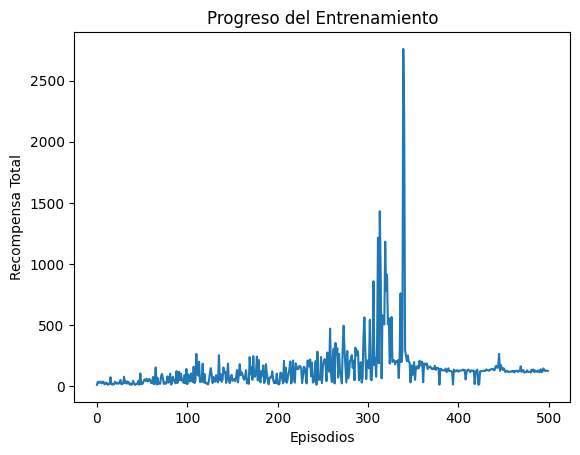

In [33]:
plt.plot(rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Total')
plt.title('Progreso del Entrenamiento')
plt.show()

In [34]:
def evaluate_agent(env, policy_net, num_eval_episodes=100):
    total_rewards = []

    for _ in range(num_eval_episodes):
        state, info = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state)).argmax().item()
            
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)

    avg_reward = sum(total_rewards) / num_eval_episodes
    return avg_reward

eval_env = gym.make("CartPole-v1")

average_reward = evaluate_agent(eval_env, policy_net)
print(f"Recompensa promedio en la evaluación: {average_reward}")

eval_env.close()


c:\Users\erick\OneDrive\Documentos\UVG\8vo. Semestre\DL\labs\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
